#**Research Challenge**

<div style="background-color: #f8d7da; border-left: 6px solid #ccc; margin: 20px; padding: 15px;">
    <strong>💡 Margaret Atwood:</strong> Every aspect of human technology has a dark side, including the bow and arrow.
</div>

## 🏅 Build your own model

You have been assigned one dataset from [MatBench](https://matbench.materialsproject.org) as introduced in the [Lecture slides](https://speakerdeck.com/aronwalsh/mlformaterials-challenge-25). You are free to choose and tune any machine-learning model, with any Python library, but it should be appropriate for the problem. For instance, [XGBoost](https://xgboost.readthedocs.io) could be a good starting starting point to build a regression model. You can refer back to earlier notebooks and repurpose code as needed.

You may reach the limits of computing processing power on Google Colab. Building a useful model with limited resources is a real-world skill. Using other free resources is allowed if you find an alternative service, as is running on your own computer. A model tracker such as [wandb](https://wandb.ai) could be helpful for advanced users. If you want to try a brute force approach, a library such as [Automatminer](https://hackingmaterials.lbl.gov/automatminer) may be of interest.

This notebook should be used for keeping a record of your model development, submission, and even your presentation. You are free to edit (add/remove/delete) or rearrange the cells as you see fit.

### Your details

In [ ]:
import numpy as np

# Insert your values
Name = "Suleyman Bihi" # Replace with your name
CID = 1775504 # Replace with your College ID (as a numeric value with no leading 0s)

# Set a random seed using the CID value
CID = int(CID)
np.random.seed(CID)

# Print the message
print("This is the work of " + Name + " [CID: " + str(CID) + "]")

This is the work of Suleyman Bihi [CID: 1775504]


## **Problem statement**

**Task:** You have been assigned one dataset from the [list](https://matbench.materialsproject.org/Benchmark%20Info/matbench_v0.1/) on [MatBench](https://matbench.materialsproject.org). You should state what problem you are trying to solve and comment on the best-performing model in the benchmark.

This notebook aims to achieve and involves developing an effective machine-learning model to predict the refractive index, *n*, of a material. My aim and goal is to produce a much faster regression model that can provide mean MAE values lower than 0.5988, corresponding to CGCNN v2019 (the worst performing ML model on the Matbench [table ](https://matbench.materialsproject.org/Leaderboards%20Per-Task/matbench_v0.1_matbench_dielectric/).

The best perfoming model on the Matbench Dielectric dataset is MODNet(v0.1.12) - Materials Optimal Descriptor Network - a feed-forward neural network. Due to its use of a nested hyperparameter optimisation process, this model is quite demanding in terms of computational resources. For this research challenge, however, we are focusing on traditional machine-learning models that can be run locally on a CPU within a few hours or less depending on the available compute power.

In [ ]:
# Install libraries (quiet mode minimizes output)
!pip install matminer --quiet         # Materials dataset & featurisation
!pip install pymatgen --quiet          # Materials analysis
!pip install prettytable --quiet       # Pretty table formatting
!pip install megnet --quiet            # MEGNet for materials modeling
!pip install shap --quiet              # SHAP for explainability
!pip install scikit-optimize           # Bayesian hyperparameter optimization

# Suppress warnings to reduce output clutter
import warnings
warnings.filterwarnings("ignore")

# Core libraries for data manipulation and visualization
import sklearn                         # General ML functions
import pandas as pd                    # Data manipulation
import matplotlib.pyplot as plt        # Plotting
import seaborn as sns                  # Advanced visualization
import skopt                           # Optimization library

# Scikit-learn: Metrics, model selection, and models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score    # Evaluation metrics
from sklearn.model_selection import cross_val_score, GridSearchCV                # CV and hyperparameter tuning
from sklearn.ensemble import RandomForestRegressor                               # Random Forest model
from sklearn.svm import SVR                                                      # Support Vector Regression
import xgboost as xgb                                                            # XGBoost framework
from xgboost import XGBRegressor                                                 # XGBoost regressor
from sklearn.inspection import permutation_importance                            # Feature importance


# Pretty printing and tabular output
from prettytable import PrettyTable      # Neat table formatting
from tabulate import tabulate            # Tabular data display


## **Data preparation**

Check the data distribution in the Matbench_dielectric dataset and apply appropriate pre-processing steps as required.

In [122]:
# Get dataset info from matminer
from matminer.datasets import get_all_dataset_info
from matminer.datasets import load_dataset

# Uncomment the info line for your assigned challenge

  # A (GTAs - Xia, Kinga)
info = get_all_dataset_info("matbench_dielectric")

  # B (GTAs - Irea, Pan)
#info = get_all_dataset_info("matbench_expt_gap")

  # C (GTAs - Yifan, Fintan)
#info = get_all_dataset_info("matbench_glass")

# Check the dataset information
print(info)

Dataset: matbench_dielectric
Description: Matbench v0.1 test dataset for predicting refractive index from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having refractive indices less than 1 and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	n: Target variable. Refractive index (unitless).
	structure: Pymatgen Structure of the material.
Num Entries: 4764
Reference: Petousis, I., Mrdjenovich, D., Ballouz, E., Liu, M., Winston, D.,
Chen, W., Graf, T., Schladt, T. D., Persson, K. A. & Prinz, F. B.
High-throughput screening of inorganic compounds for the discovery
of novel dielectric and optical materials. Sci. Data 4, 160134 (2017).
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexan

In [123]:
# Load your dataset into a pandas DataFrame
df = load_dataset("matbench_dielectric")

print(df)

                                              structure         n
0     [[4.29304147 2.4785886  1.07248561] S, [4.2930...  1.752064
1     [[3.95051434 4.51121437 0.28035002] K, [4.3099...  1.652859
2     [[-1.78688104  4.79604117  1.53044621] Rb, [-1...  1.867858
3     [[4.51438064 4.51438064 0.        ] Mn, [0.133...  2.676887
4     [[-4.36731958  6.8886097   0.50929706] Li, [-2...  1.793232
...                                                 ...       ...
4759  [[ 2.79280881  0.12499663 -1.84045389] Ca, [-2...  2.136837
4760  [[0.         5.50363806 3.84192106] O, [4.7662...  2.690619
4761  [[0. 0. 0.] Ba, [ 0.23821924  4.32393487 -0.35...  2.811494
4762  [[0.         0.18884638 0.        ] K, [0.    ...  1.832887
4763  [[0. 0. 0.] Cs, [2.80639641 2.80639641 2.80639...  2.559279

[4764 rows x 2 columns]


##**Feature Engineering**

Various experimental studies have demonstrated that a material’s refractive index is strongly determined by its composition and structure. For example, in a study published in [Applied Surface Science](https://doi.org/10.1016/j.optcom.2007.12.030), researchers showed that variations in electronegativity and density—attributes directly tied to the elemental makeup and atomic packing—have a significant effect on the refractive index.

Based on these findings and after reviewing the  [matminer](https://hackingmaterials.lbl.gov/matminer/)  documentation,, I have chosen two featurisers:

* **ElementProperty:**
Captures compositional attributes such as electronegativity and atomic radius. These features serve as proxies for atomic polarizability, which is a key factor influencing the optical response of materials.

* **SineCoulombMatrix:**
Encodes structural information by representing interatomic distances under periodic boundary conditions. This featuriser effectively captures how the crystal structure—specifically the arrangement and spacing of atoms—impacts the refractive index.

These featurisers have been successfully applied in prior models like [RF-SCM/Magpie](https://matbench.materialsproject.org/Full%20Benchmark%20Data/matbench_v0.1_rf/), underscoring their suitability for building a robust predictive regressor model for dielectric properties.

In [124]:
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.matrix import SineCoulombMatrix


# Adding a composition column to the df using the composition property of the Structure class and a lambda function
df['composition'] = df.structure.apply(lambda x: x.composition )

# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however, this can slow performance, we disable it
el_prop_featuriser.set_n_jobs(1)

featurizer_scm = SineCoulombMatrix()
df = featurizer_scm.fit_featurize_dataframe(df, col_id='structure')
# Featurise the dataframe using the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition')

# Print the shape of the DataFrame
print(df.shape)
df.head()

SineCoulombMatrix:   0%|          | 0/4764 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/4764 [00:00<?, ?it/s]

(4764, 423)


,structure,n,composition,sine coulomb matrix eig 0,sine coulomb matrix eig 1,sine coulomb matrix eig 2,sine coulomb matrix eig 3,sine coulomb matrix eig 4,sine coulomb matrix eig 5,sine coulomb matrix eig 6,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,"[[4.29304147 2.4785886 1.07248561] S, [4.2930...",1.752064,"(S, K)",774.461537,425.789759,355.992717,354.510043,370.079145,380.152373,377.962228,...,0.000000,0.000000,0.000000,0.0,70.0,229.0,159.0,149.500000,79.500000,70.0
1,"[[3.95051434 4.51121437 0.28035002] K, [4.3099...",1.652859,"(K, V, O)",1167.323585,697.091075,522.540141,580.540237,552.597621,558.156884,908.623977,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,120.500000,108.500000,12.0
2,"[[-1.78688104 4.79604117 1.53044621] Rb, [-1...",1.867858,"(Rb, Zr, O)",3816.854768,3372.047081,3043.372718,2843.808349,2759.496376,2778.206528,92.366534,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,114.666667,102.666667,12.0
3,"[[4.51438064 4.51438064 0. ] Mn, [0.133...",2.676887,"(Mn, O, F)",1293.782818,1093.693133,117.818851,92.645552,86.983572,65.258820,72.811012,...,0.000310,0.000103,0.000138,0.0,12.0,217.0,205.0,81.333333,90.444444,12.0
4,"[[-4.36731958 6.8886097 0.50929706] Li, [-2...",1.793232,"(Li, Co, Si, O)",1363.966529,281.692178,6.203157,7.550029,82.493382,68.225096,67.329552,...,1.548471,0.193559,0.338728,0.0,12.0,229.0,217.0,115.875000,103.875000,12.0


##**Data Integrity Verification**

After applying the featurisers, it's crucial to verify the integrity of your dataset before proceeding to modeling. Perform checks for any NA values within the df. As the cell below determined there are no NA values that we have to filter/replace, data preparation can now be perfomed.This ensure that your dataframe is clean, consistent, and optimised for further analysis.

In [125]:
# Identify columns containing missing values and counts them
na_columns = df.columns[df.isna().any()]

if not na_columns.empty:
    print("Columns with NA values and their counts:")
    for col in na_columns:
        print(f"{col}: {df[col].isna().sum()} missing values")
else:
    print("No columns with NA values found.")


No columns with NA values found.


## **Scaling - MinMax**

After verifying the integrity of the dataset, the next crucial step is to standardise the features using MinMax scaling. To visualise the distribution of the raw (pre-scaled) features, a plot was created to understand their initial ranges and identify any potential issues. After applying MinMax scaling—which transforms all feature values to the [0, 1] range — a re-plot is conducted on the distributions (post-scaled) to confirm that the normalisation process has effectively standardised the data. This pre- and post-scaling visualisation ensures that the dataframe is clean, consistent, and optimised for the modeling later. MinMax scaling also ensures consistent feature ranges without altering the underlying distribution, which is particularly important for SVR and can offer additional benefits in terms of convergence and stability for RF and XGB.

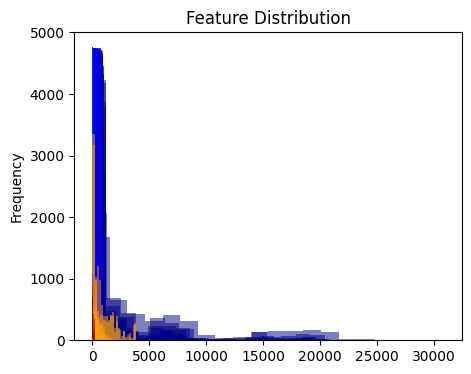

In [126]:
# Extract feature columns, excluding the first three columns
feature_columns = df.columns[3:]
df_original = df.copy()  # Preserve the original DataFrame

# Generate unique colours for each feature for better visualisation
colours = [plt.cm.jet(i / float(len(feature_columns))) for i in range(len(feature_columns))]

# Plot the distribution of features using histograms
plt.figure(figsize=(5, 4))
for i, column in enumerate(feature_columns):
    df[column].plot(kind='hist', bins=20, alpha=0.5, color=colours[i], label=column)

plt.title('Feature Distribution')
plt.show()

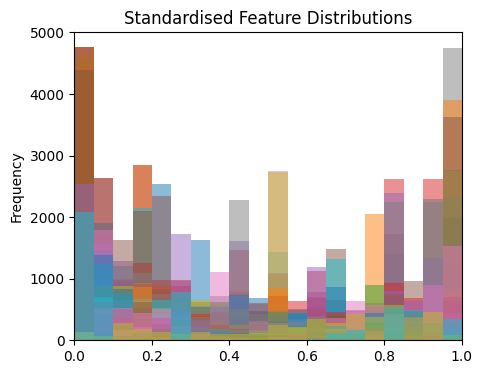

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = df.copy()
scaled_df_original = df.copy()  # Preserve the original DataFrame

# Normalize the feature columns to a range of [0,1]
scaler = MinMaxScaler()
scaled_df[feature_columns] = scaler.fit_transform(scaled_df[feature_columns])
scaled_df_original[feature_columns] = scaler.fit_transform(scaled_df[feature_columns])  # Duplicate scaling

# Plot the normalized feature distributions
plt.figure(figsize=(5, 4))
for column in feature_columns:
    scaled_df[column].plot(kind='hist', bins=20, alpha=0.5, label=column)
plt.xlim(0,1)  # Limit x-axis to [0,1] as features are scaled
plt.title('Standardised Feature Distributions')
plt.show()

Next, modifying the dataset to prepare the X and y values for training and testing is done. Specifically, we remove the non-numerical features and isolate the target variable (refractive index), resulting in a numerical X values for further analysis.

In [128]:
# Define the features to exclude from the dataset
features_to_drop = ['structure', 'n', 'composition']

# Select the remaining feature columns
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Extract feature values as an array
x = df[feature_cols].values
scaled_X = scaled_df[feature_cols].values  # Scaled version of features

# Extract target variable values
y = df['n'].values

## **K-Means Clustering**

To better understand the distribution of the target variable, K-Means clustering was applied as an exploratory visualization technique. The goal was to determine whether the target values exhibited natural groupings that could provide insights into the dataset’s structure. Since the number of clusters (K) was unknown beforehand, the silhouette score was used to identify the optimal value of K, ensuring that the clusters were well-separated and meaningful.

Silhouette Score for k=2: 0.9674
Silhouette Score for k=3: 0.9368
Silhouette Score for k=4: 0.7553
Silhouette Score for k=5: 0.6832
Silhouette Score for k=6: 0.6042
Silhouette Score for k=7: 0.5939
Silhouette Score for k=8: 0.5810
Silhouette Score for k=9: 0.5451

Best number of clusters is 2 with a silhouette score of 0.9674


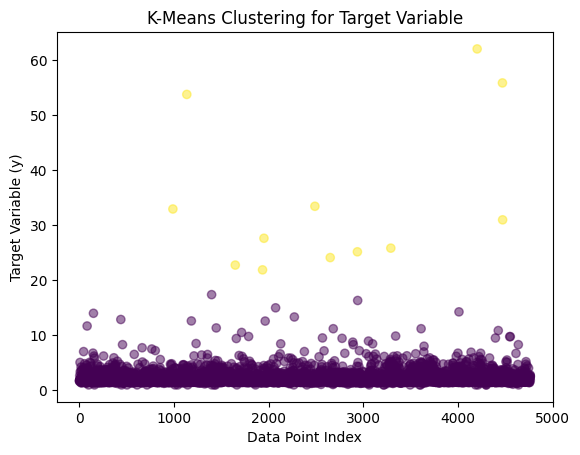

In [129]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reshape it into a 2D array for clustering:
y_rs = y.reshape(-1, 1)

#Find the best number of clusters (k) using the silhouette score
k_values = range(2, 10)  # range of K values
best_k = None
best_score = -1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(y_rs)
    labels = kmeans.labels_

    # Calculate the silhouette score for the current k
    score = silhouette_score(y_rs, labels)
    print(f"Silhouette Score for k={k}: {score:.4f}")

    # Keeps track of the best (highest) silhouette score
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest number of clusters is {best_k} with a silhouette score of {best_score:.4f}")

# Fit KMeans again using the best number of clusters
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
kmeans_final.fit(y_rs)

# Assign each data point to a cluster
y_clusters = kmeans_final.labels_

# Plot the clustering results
plt.scatter(range(len(y)), y, c=y_clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering for Target Variable')
plt.xlabel('Data Point Index')
plt.ylabel('Target Variable (y)')
plt.show()

From visual inspection, three clusters would have better suited the data, as most refractive index values are below ~10, with a few mid-range values (10–30) and a small set of outliers above 30. While the silhouette score determined the optimal K mathematically, a three-cluster approach would align more intuitively with the data’s natural distribution.


##**Testing & Training**
The train-test split is now performed with the usual practise of an 80/20 train-test split which would allow the model to be trained and validated effectively.

In [130]:
from sklearn.model_selection import train_test_split

features_to_drop = ['structure','n', 'composition']
feature_cols = [col for col in list(df_original.columns) if col not in features_to_drop]

# Get an array of the features
X = df_original[feature_cols].values
scaled_X = scaled_df_original[feature_cols].values


y = df['n'].values

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

# Print the sizes of the arrays
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (3811, 420)
y_train shape: (3811,)
X_test shape: (953, 420)
y_test shape: (953,)


Train, validate and test your model. Make sure to do proper data splits and to consider the hyperparamaters of your model.

##**Model Selection**

Three widely recognised machine learning models are employed to predict the refractive index: Support Vector Regression (SVR), XGBoost (XGB), and Random Forest (RF). Each model offers unique advantages and has been validated in the literature for materials informatics applications.

**SVR:**

Support Vector Regression is a kernel-based approach that excels in modeling complex non-linear relationships and interactions which will work well with material optical properties like refractive index. In the study by [Einabadi and Mashkoori (2024)](Dhttps://doi.org/10.1038/s41598-024-73551-0), SVR with an RBF kernel was used to predict the refractive index of inorganic compounds, effectively capturing the complex relationships between atomic-level descriptors and optical properties.

**XGB:**

XGBoost is a gradient boosting framework known for its speed and high predictive accuracy, particularly when dealing with high-dimensional datasets. [Ahmad et al.(2022)](https://doi.org/10.1155/2022/9415863) demonstrated its capability in predicting shear strength for rockfill materials, which underscores its effectiveness in capturing physical related properities in materials data.

**RF:**

RF employs an ensemble of decision trees to provide robust predictions and improve interpretability by mitigating overfitting. Studies, such as [Filanovich et al. (2020)](https://doi.org/10.1109/USBEREIT48449.2020.9117689), have shown that RF and other models can effectively predict material properties like lattice characteristics of materials, making it a solid choice for refractive index regression.
Together, these models will hopefully provide a diverse and complementary approach, capturing non-linear interactions (SVR), high-dimensional feature patterns (XGBoost), and robust ensemble predictions (Random Forest) for accurate refractive index prediction.

## **Hyperparameter Optimisation**

**WARNING** - the following cells have a long runtime and use 10 fold cross validation to determine the best parameters for each model.

In [ ]:
# # Commented out ---> Warning! This cell will take approximately 1 hour 30 minutes to execute,
# # even with a limited search space compared to other models on Matbench.

## ----------------- SVR Model ----------------- ##

# # Define the hyperparameter grid for SVR
# svr_param_grid = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Type of kernel function
#     'C': [0.1, 1, 10],                               # Regularisation strength
#     'degree': [2, 3, 4],                             # Degree for 'poly' kernel (ignored otherwise)
#     'gamma': ['scale', 'auto'],                      # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'epsilon': [0.1, 0.2, 0.3],                      # Epsilon in the epsilon-SVR model (insensitive loss)
# }

# # Perform Grid Search with cross-validation (10-fold CV)
# svr_grid_search = GridSearchCV(SVR(), svr_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
# svr_grid_search.fit(X_train, y_train)

# # Extract the best hyperparameters from Grid Search
# best_svr_params = svr_grid_search.best_params_
# best_svr_model = svr_grid_search.best_estimator_
# print("Best SVR Parameters:", best_svr_params)

# # Evaluate the best model using cross-validation
# mse_scores_svr = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
# rmse_scores_svr = np.sqrt(mse_scores_svr)
# mae_scores_svr = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# # Print SVR performance metrics
# print("SVR - Mean MSE:", np.mean(mse_scores_svr))
# print("SVR - Std MSE:", np.std(mse_scores_svr))
# print("SVR - Mean RMSE:", np.mean(rmse_scores_svr))
# print("SVR - Std RMSE:", np.std(rmse_scores_svr))
# print("SVR - Mean MAE:", np.mean(mae_scores_svr))
# print("SVR - Std MAE:", np.std(mae_scores_svr))

In [ ]:
# # Commented out ---> Warning: This cell will take approximately 2 hours 30 minutes to execute!

## ----------------- Random Forest Model ----------------- ##

# # Define the hyperparameter grid for Random Forest
# rf_param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of trees in the forest
#    'max_depth': [10, 20, 30],  # Maximum depth of each tree
#    'min_samples_split': [2, 4, 6]  # Minimum samples required to split a node
# }

# # Perform Grid Search with cross-validation (10-fold CV)
# rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
# rf_grid_search.fit(X_train, y_train)

# # Extract the best hyperparameters from Grid Search
# best_rf_params = rf_grid_search.best_params_
# best_rf_model = rf_grid_search.best_estimator_

# print("Best RF Parameters:", best_rf_params)

# # Evaluate the best model using cross-validation
# mse_scores_rf = -cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
# rmse_scores_rf = np.sqrt(mse_scores_rf)
# mae_scores_rf = -cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# # Print Random Forest performance metrics
# print("Random Forest - Mean MSE:", np.mean(mse_scores_rf))
# print("Random Forest - Std MSE:", np.std(mse_scores_rf))
# print("Random Forest - Mean RMSE:", np.mean(rmse_scores_rf))
# print("Random Forest - Std RMSE:", np.std(rmse_scores_rf))
# print("Random Forest - Mean MAE:", np.mean(mae_scores_rf))
# print("Random Forest - Std MAE:", np.std(mae_scores_rf))

In [ ]:
# # Commented out ---> Warning: This cell will take approximately 1 hour 30 minutes to execute!

## ----------------- XGBoost Model ----------------- ##

# # Define the hyperparameter grid for XGBoost
# xgb_param_grid = {
#    'n_estimators': [100, 200, 300],  # Number of boosting rounds
#    'max_depth': [10, 20, 30],  # Maximum depth of each tree
#    'learning_rate': [0.1, 0.2, 0.3]  # Step size shrinkage to prevent overfitting
# }

# # Perform Grid Search with cross-validation (10-fold CV)
# xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42), xgb_param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
# xgb_grid_search.fit(X_train, y_train)

# # Extract the best hyperparameters from Grid Search
# best_xgb_params = xgb_grid_search.best_params_
# best_xgb_model = xgb_grid_search.best_estimator_

# print("Best XGB Parameters:", best_xgb_params)

# # Evaluate the best model using cross-validation
# mse_scores_xgb = -cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
# rmse_scores_xgb = np.sqrt(mse_scores_xgb)
# mae_scores_xgb = -cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# # Print XGBoost performance metrics
# print("XGBoost - Mean MSE:", np.mean(mse_scores_xgb))
# print("XGBoost - Std MSE:", np.std(mse_scores_xgb))
# print("XGBoost - Mean RMSE:", np.mean(rmse_scores_xgb))
# print("XGBoost - Std RMSE:", np.std(rmse_scores_xgb))
# print("XGBoost - Mean MAE:", np.mean(mae_scores_xgb))
# print("XGBoost - Std MAE:", np.std(mae_scores_xgb))


The 3 cells above perform the hyperparameter optimisation and Cross Validation. The best hyperparameters for the 3 different models are:

**SVR** -
`best_svr_model = SVR(C=10, degree=4, epsilon=0.3, gamma='scale', kernel='poly')`

**RF** - `best_rf_model = RandomForestRegressor(max_depth=20, min_samples_split=6, n_estimators=300)`

**XGBoost** - `best_xgb_model = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=300)`

**WARNING** - The following cell takes more than 55 mins to run, but has the optimised models that can be run on the test data to to evaluate their performance on unseen data which is crucial to assess the generalisation of the chosen models and parameters.

In [131]:
# SVR Model
# Define and cross-validate the best SVR model
best_svr_model = SVR(C=10, degree=4, epsilon=0.3, gamma='scale', kernel='poly')

mse_scores_svr = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_scores_svr = np.sqrt(mse_scores_svr)
mae_scores_svr = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
r2_scores_svr = cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='r2')

#  Print concise cross-validation metrics
print("== SVR Cross-Validation ==")
print(f"MSE  (mean ± std): {np.mean(mse_scores_svr):.3f} ± {np.std(mse_scores_svr):.3f}")
print(f"RMSE (mean ± std): {np.mean(rmse_scores_svr):.3f} ± {np.std(rmse_scores_svr):.3f}")
print(f"MAE  (mean ± std): {np.mean(mae_scores_svr):.3f} ± {np.std(mae_scores_svr):.3f}")
print(f"R²   (mean ± std): {np.mean(r2_scores_svr):.3f} ± {np.std(r2_scores_svr):.3f}\n")

# Train on entire training set and evaluate on test set
best_svr_model.fit(X_train, y_train)
svr_test_preds = best_svr_model.predict(X_test)

svr_test_mse = mean_squared_error(y_test, svr_test_preds)
svr_test_rmse = np.sqrt(svr_test_mse)
svr_test_mae = mean_absolute_error(y_test, svr_test_preds)
svr_test_r2 = r2_score(y_test, svr_test_preds)

print("== SVR Test Performance ==")
print(f"MSE : {svr_test_mse:.3f}")
print(f"RMSE: {svr_test_rmse:.3f}")
print(f"MAE : {svr_test_mae:.3f}")
print(f"R²  : {svr_test_r2:.3f}\n")


# Random Forest Model
best_rf_model = RandomForestRegressor(max_depth=20, min_samples_split=6, n_estimators=300)

mse_scores_rf = -cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_scores_rf = np.sqrt(mse_scores_rf)
mae_scores_rf = -cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
r2_scores_rf = cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='r2')

print("== Random Forest Cross-Validation ==")
print(f"MSE  (mean ± std): {np.mean(mse_scores_rf):.3f} ± {np.std(mse_scores_rf):.3f}")
print(f"RMSE (mean ± std): {np.mean(rmse_scores_rf):.3f} ± {np.std(rmse_scores_rf):.3f}")
print(f"MAE  (mean ± std): {np.mean(mae_scores_rf):.3f} ± {np.std(mae_scores_rf):.3f}")
print(f"R²   (mean ± std): {np.mean(r2_scores_rf):.3f} ± {np.std(r2_scores_rf):.3f}\n")

best_rf_model.fit(X_train, y_train)
rf_test_preds = best_rf_model.predict(X_test)

rf_test_mse = mean_squared_error(y_test, rf_test_preds)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_test_mae = mean_absolute_error(y_test, rf_test_preds)
rf_test_r2 = r2_score(y_test, rf_test_preds)

print("== Random Forest Test Performance ==")
print(f"MSE : {rf_test_mse:.3f}")
print(f"RMSE: {rf_test_rmse:.3f}")
print(f"MAE : {rf_test_mae:.3f}")
print(f"R²  : {rf_test_r2:.3f}\n")


# XGBoost Model
best_xgb_model = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=300)

mse_scores_xgb = -cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rmse_scores_xgb = np.sqrt(mse_scores_xgb)
mae_scores_xgb = -cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
r2_scores_xgb = cross_val_score(best_xgb_model, X_train, y_train, cv=10, scoring='r2')

print("== XGBoost Cross-Validation ==")
print(f"MSE  (mean ± std): {np.mean(mse_scores_xgb):.3f} ± {np.std(mse_scores_xgb):.3f}")
print(f"RMSE (mean ± std): {np.mean(rmse_scores_xgb):.3f} ± {np.std(rmse_scores_xgb):.3f}")
print(f"MAE  (mean ± std): {np.mean(mae_scores_xgb):.3f} ± {np.std(mae_scores_xgb):.3f}")
print(f"R²   (mean ± std): {np.mean(r2_scores_xgb):.3f} ± {np.std(r2_scores_xgb):.3f}\n")

best_xgb_model.fit(X_train, y_train)
xgb_test_preds = best_xgb_model.predict(X_test)

xgb_test_mse = mean_squared_error(y_test, xgb_test_preds)
xgb_test_rmse = np.sqrt(xgb_test_mse)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_preds)
xgb_test_r2 = r2_score(y_test, xgb_test_preds)

print("== XGBoost Test Performance ==")
print(f"MSE : {xgb_test_mse:.3f}")
print(f"RMSE: {xgb_test_rmse:.3f}")
print(f"MAE : {xgb_test_mae:.3f}")
print(f"R²  : {xgb_test_r2:.3f}\n")


== SVR Cross-Validation ==
MSE  (mean ± std): 4.200 ± 5.104
RMSE (mean ± std): 1.710 ± 1.130
MAE  (mean ± std): 0.416 ± 0.102
R²   (mean ± std): 0.341 ± 0.232

== SVR Test Performance ==
MSE : 1.356
RMSE: 1.164
MAE : 0.338
R²  : 0.351

== Random Forest Cross-Validation ==
MSE  (mean ± std): 4.893 ± 5.053
RMSE (mean ± std): 1.931 ± 1.079
MAE  (mean ± std): 0.451 ± 0.107
R²   (mean ± std): 0.054 ± 0.350

== Random Forest Test Performance ==
MSE : 1.543
RMSE: 1.242
MAE : 0.362
R²  : 0.262

== XGBoost Cross-Validation ==
MSE  (mean ± std): 5.829 ± 4.771
RMSE (mean ± std): 2.226 ± 0.935
MAE  (mean ± std): 0.503 ± 0.105
R²   (mean ± std): -0.497 ± 0.786

== XGBoost Test Performance ==
MSE : 2.533
RMSE: 1.592
MAE : 0.380
R²  : -0.211



In [132]:
import time

# Dictionary to store training times
training_times_bp = {}

# Measure training time for SVR
start_time = time.time()
best_svr_model.fit(X_train, y_train)
training_times_bp["SVR"] = time.time() - start_time

# Measure training time for Random Forest
start_time = time.time()
best_rf_model.fit(X_train, y_train)
training_times_bp["RandomForest"] = time.time() - start_time

# Measure training time for XGBoost
start_time = time.time()
best_xgb_model.fit(X_train, y_train)
training_times_bp["XGBoost"] = time.time() - start_time

# Print out the results
print("Training Time Comparison (seconds):")
for model_name, elapsed_time in training_times_bp.items():
    print(f"{model_name}: {elapsed_time:.3f}s")


Training Time Comparison (seconds):
SVR: 2.199s
RandomForest: 99.685s
XGBoost: 14.072s


The cell above uses the time module to record how long it takes each of the three best-parameter models to fit on the training data. Tracking training time is essential for comparing computational costs and assessing the feasibility of each model, especially when dealing with larger datasets or real-time applications.

##**Model analysis and discussion**


 To analyse and assess the models, a variety of plots with the outputted metrics will be produced to compare the performance of the different models on all of the folds of the training sets.

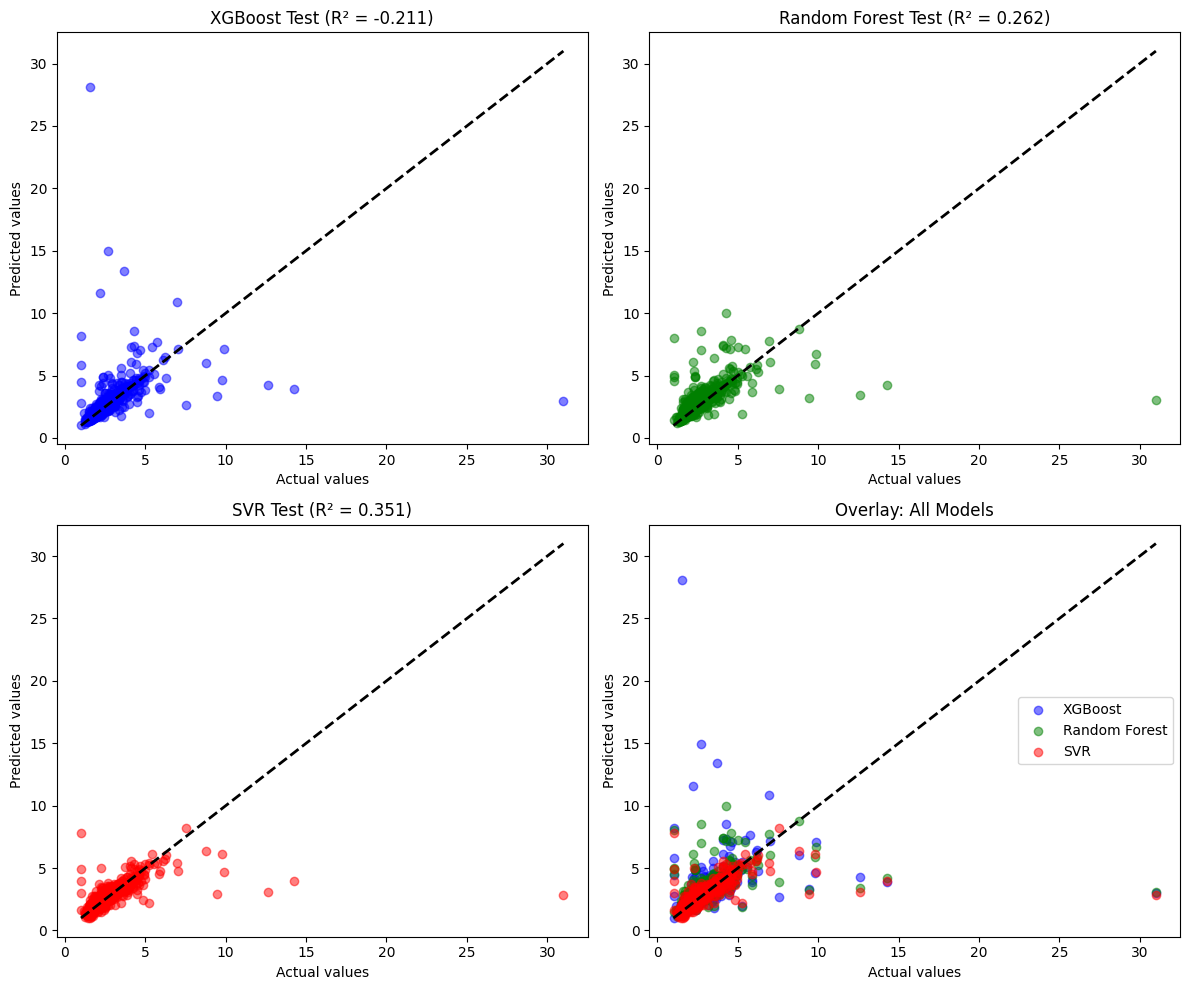

In [133]:
# Set up a grid to plot all the charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# XGBoost Predictions
axes[0, 0].scatter(y_test, xgb_test_preds, c='blue', alpha=0.5, label='XGBoost')
axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
axes[0, 0].set_xlabel("Actual values")
axes[0, 0].set_ylabel("Predicted values")
axes[0, 0].set_title(f"XGBoost Test (R² = {xgb_test_r2:.3f})")

# Random Forest Predictions
axes[0, 1].scatter(y_test, rf_test_preds, c='green', alpha=0.5, label='Random Forest')
axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
axes[0, 1].set_xlabel("Actual values")
axes[0, 1].set_ylabel("Predicted values")
axes[0, 1].set_title(f"Random Forest Test (R² = {rf_test_r2:.3f})")

# SVR Predictions
axes[1, 0].scatter(y_test, svr_test_preds, c='red', alpha=0.5, label='SVR')
axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
axes[1, 0].set_xlabel("Actual values")
axes[1, 0].set_ylabel("Predicted values")
axes[1, 0].set_title(f"SVR Test (R² = {svr_test_r2:.3f})")

# Overlay Plot
axes[1, 1].scatter(y_test, xgb_test_preds, c='blue', alpha=0.5, label='XGBoost')
axes[1, 1].scatter(y_test, rf_test_preds, c='green', alpha=0.5, label='Random Forest')
axes[1, 1].scatter(y_test, svr_test_preds, c='red', alpha=0.5, label='SVR')
axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
axes[1, 1].set_xlabel("Actual values")
axes[1, 1].set_ylabel("Predicted values")
axes[1, 1].set_title("Overlay: All Models")
axes[1, 1].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


These four subplots show how each model’s predictions compare with the actual refractive index values. The diagonal line indicates perfect agreement between predictions and observations. XGBoost and Random Forest both exhibit negative r^2 scores, signifying that they are performing worse than a simple mean predictor. SVR, with an r^2 of 0.241, shows tighter clustering around the diagonal, indicating comparatively better accuracy. In the combined overlay, the SVR points (red) tend to be closer to the diagonal than the Random Forest (green) and XGBoost (blue) predictions, highlighting **SVR’s better performance** under the current setup.

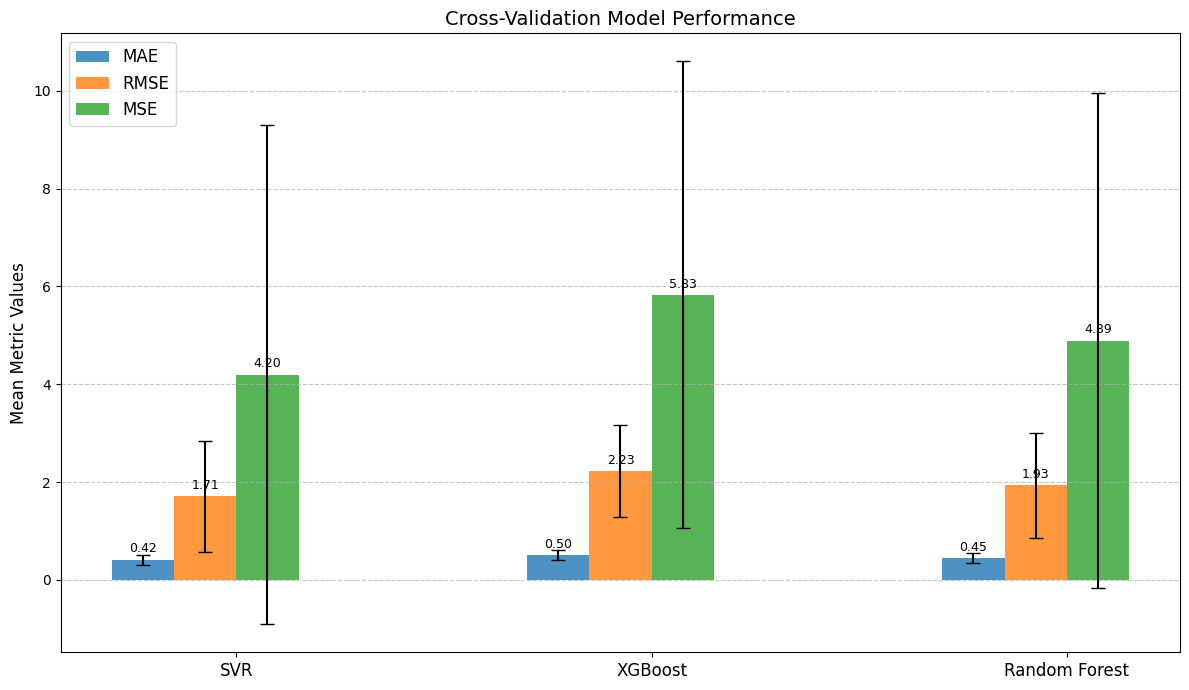

In [135]:
# Compute means and standard deviations for each metric
mae_means = [np.mean(mae_scores_svr), np.mean(mae_scores_xgb), np.mean(mae_scores_rf)]
mae_stds  = [np.std(mae_scores_svr),  np.std(mae_scores_xgb),  np.std(mae_scores_rf)]

rmse_means = [np.mean(rmse_scores_svr), np.mean(rmse_scores_xgb), np.mean(rmse_scores_rf)]
rmse_stds  = [np.std(rmse_scores_svr),  np.std(rmse_scores_xgb),  np.std(rmse_scores_rf)]

mse_means = [np.mean(mse_scores_svr), np.mean(mse_scores_xgb), np.mean(mse_scores_rf)]
mse_stds  = [np.std(mse_scores_svr),  np.std(mse_scores_xgb),  np.std(mse_scores_rf)]

r2_means = [np.mean(r2_scores_svr), np.mean(r2_scores_xgb), np.mean(r2_scores_rf)]
r2_stds  = [np.std(r2_scores_svr),  np.std(r2_scores_xgb),  np.std(r2_scores_rf)]

# Model names and x-axis positions
models = ['SVR', 'XGBoost', 'Random Forest']
x = np.arange(len(models))

# Set bar width and positions for four metrics
bar_width = 0.15
x1 = x - 1.5 * bar_width  # MAE
x2 = x - 0.5 * bar_width  # RMSE
x3 = x + 0.5 * bar_width  # MSE

# Create the figure and axis
plt.figure(figsize=(12, 7))

# Plot bars with error bars
bars1 = plt.bar(x1, mae_means, width=bar_width, yerr=mae_stds, label='MAE', capsize=5, alpha=0.8)
bars2 = plt.bar(x2, rmse_means, width=bar_width, yerr=rmse_stds, label='RMSE', capsize=5, alpha=0.8)
bars3 = plt.bar(x3, mse_means, width=bar_width, yerr=mse_stds, label='MSE', capsize=5, alpha=0.8)

# Function to annotate bars with their mean values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # vertical offset in points
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)


# Set x-ticks and labels
plt.xticks(x, models, fontsize=12)
plt.ylabel('Mean Metric Values', fontsize=12)
plt.title('Cross-Validation Model Performance', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


The bar chart above compares the mean MAE, RMSE, and MSE for each model based on cross-validation. **SVR has the lowest MAE and RMSE, suggesting it consistently produces smaller errors across folds**. XGBoost, while capable of strong performance in other contexts, exhibits the highest RMSE and MSE here, indicating that a subset of predictions are significantly off-target. Random Forest shows moderate errors but does not match SVR’s accuracy. The relatively large error bars, especially for XGBoost, highlight variability in performance across different folds.

In [136]:

#CROSS-VALIDATION RESULTS TABLE
cv_table = PrettyTable()

# Update the field names to include R² columns
cv_table.field_names = [
    "Model",
    "Mean MAE", "Std MAE",
    "Mean RMSE", "Std RMSE",
    "Mean MSE", "Std MSE",
    "Mean R²", "Std R²"
]

# Add SVR row
cv_table.add_row([
    "SVR",
    f"{np.mean(mae_scores_svr):.3f}", f"{np.std(mae_scores_svr):.3f}",
    f"{np.mean(rmse_scores_svr):.3f}", f"{np.std(rmse_scores_svr):.3f}",
    f"{np.mean(mse_scores_svr):.3f}",  f"{np.std(mse_scores_svr):.3f}",
    f"{np.mean(r2_scores_svr):.3f}",  f"{np.std(r2_scores_svr):.3f}"
])

# Add XGBoost row
cv_table.add_row([
    "XGBoost",
    f"{np.mean(mae_scores_xgb):.3f}", f"{np.std(mae_scores_xgb):.3f}",
    f"{np.mean(rmse_scores_xgb):.3f}", f"{np.std(rmse_scores_xgb):.3f}",
    f"{np.mean(mse_scores_xgb):.3f}",  f"{np.std(mse_scores_xgb):.3f}",
    f"{np.mean(r2_scores_xgb):.3f}",  f"{np.std(r2_scores_xgb):.3f}"
])

# Add Random Forest row
cv_table.add_row([
    "Random Forest",
    f"{np.mean(mae_scores_rf):.3f}", f"{np.std(mae_scores_rf):.3f}",
    f"{np.mean(rmse_scores_rf):.3f}", f"{np.std(rmse_scores_rf):.3f}",
    f"{np.mean(mse_scores_rf):.3f}",  f"{np.std(mse_scores_rf):.3f}",
    f"{np.mean(r2_scores_rf):.3f}",  f"{np.std(r2_scores_rf):.3f}"
])

# Print the transposed cross-validation table (optional)
cv_table.transpose = True
print("Cross-validation results")
print(cv_table)

# TEST RESULTS TABLE
test_table = PrettyTable()

# Table column names
test_table.field_names = ["Model", "MAE", "RMSE", "MSE", "R²"]

# SVR row (test set)
test_table.add_row([
    "SVR",
    f"{svr_test_mae:.3f}",
    f"{svr_test_rmse:.3f}",
    f"{svr_test_mse:.3f}",
    f"{svr_test_r2:.3f}"
])

# XGBoost row (test set)
test_table.add_row([
    "XGBoost",
    f"{xgb_test_mae:.3f}",
    f"{xgb_test_rmse:.3f}",
    f"{xgb_test_mse:.3f}",
    f"{xgb_test_r2:.3f}"
])

# Random Forest row (test set)
test_table.add_row([
    "Random Forest",
    f"{rf_test_mae:.3f}",
    f"{rf_test_rmse:.3f}",
    f"{rf_test_mse:.3f}",
    f"{rf_test_r2:.3f}"
])

print("Test Results")
print(test_table)


Cross-validation results
+---------------+----------+---------+-----------+----------+----------+---------+---------+--------+
|     Model     | Mean MAE | Std MAE | Mean RMSE | Std RMSE | Mean MSE | Std MSE | Mean R² | Std R² |
+---------------+----------+---------+-----------+----------+----------+---------+---------+--------+
|      SVR      |  0.416   |  0.102  |   1.710   |  1.130   |  4.200   |  5.104  |  0.341  | 0.232  |
|    XGBoost    |  0.503   |  0.105  |   2.226   |  0.935   |  5.829   |  4.771  |  -0.497 | 0.786  |
| Random Forest |  0.451   |  0.107  |   1.931   |  1.079   |  4.893   |  5.053  |  0.054  | 0.350  |
+---------------+----------+---------+-----------+----------+----------+---------+---------+--------+
Test Results
+---------------+-------+-------+-------+--------+
|     Model     |  MAE  |  RMSE |  MSE  |   R²   |
+---------------+-------+-------+-------+--------+
|      SVR      | 0.338 | 1.164 | 1.356 | 0.351  |
|    XGBoost    | 0.380 | 1.592 | 2.533 | -0

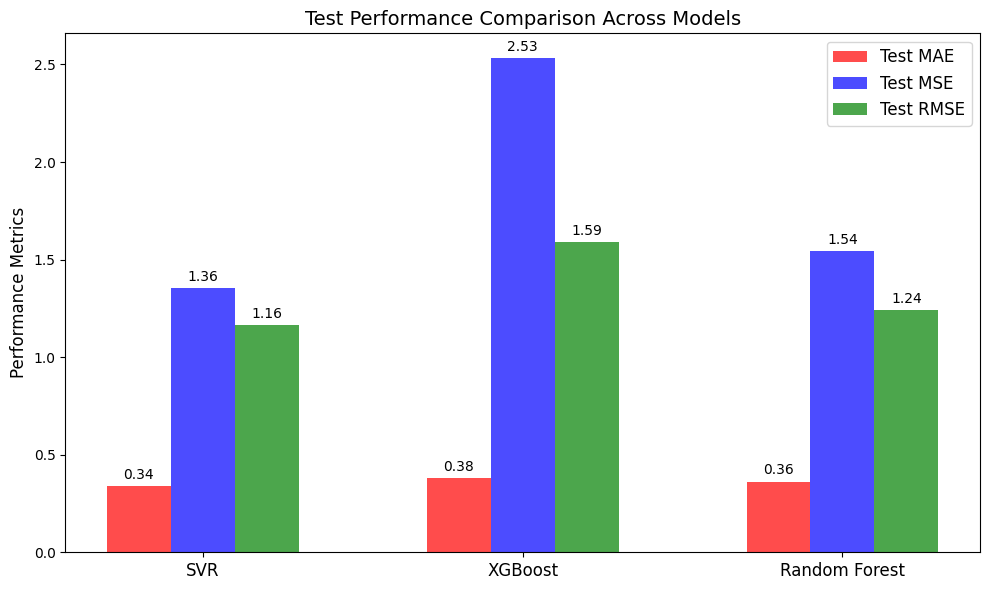

In [137]:
#Test comparison plot of the three models
# X-axis tick names
models = ['SVR', 'XGBoost', 'Random Forest']
indices = np.arange(len(models))

# Set the bar width for better visibility
bar_width = 0.2

plt.figure(figsize=(10, 6))

# Plot Test MAE, MSE, and RMSE bars
bars_mae = plt.bar(indices - bar_width,
                   [svr_test_mae, xgb_test_mae, rf_test_mae],
                   width=bar_width, color='r', label='Test MAE', alpha=0.7)

bars_mse = plt.bar(indices,
                   [svr_test_mse, xgb_test_mse, rf_test_mse],
                   width=bar_width, color='blue', label='Test MSE', alpha=0.7)

bars_rmse = plt.bar(indices + bar_width,
                    [svr_test_rmse, xgb_test_rmse, rf_test_rmse],
                    width=bar_width, color='green', label='Test RMSE', alpha=0.7)

# Function to annotate bars with their respective values
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Vertical offset for text
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

annotate_bars(bars_mae)
annotate_bars(bars_mse)
annotate_bars(bars_rmse)

# Customize labels, title, and grid
plt.xticks(indices, models, fontsize=12)
plt.ylabel('Performance Metrics', fontsize=12)
plt.title('Test Performance Comparison Across Models', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()


 The three models’ performance is evaluated on a held-out test set and the performance metrics are plotted. The bar heights represent the average errors, confirming that **SVR again delivers the best results** in comparison to the other models, **with the lowest MSE, RMSE, and MAE**. Random Forest places second, and XGBoost produces the highest errors. Additionally, the relatively high standard deviation shown in RMSE the table outputted in the previous cell highlights each model’s sensitivity to certain subsets of features—particularly those with high refractive index values—which are more challenging to predict accurately. This can and will be verified through Nested Cross Validation(NCV), offering a more unbiased measure of generalisation error. Overall, these findings reinforce the cross-validation trends from above, showing that **SVR generalises most effectively to unseen data under the chosen feature set and hyperparameters** and will be assessed with NCV.

##**Nested Cross-Validation**

The robustness of the SVR model is assessed by varying the training-test splits across different datasets, ensuring it generalises well without sacrificing accuracy. The NCV approach, which is also employed by the benchmark, will involve creating six distinct splits using different random_state parameters and cross validation will be perfomed to validate the model's generalisation capability.



In [138]:
# Create empty lists that will store all the metrics over the test and cross-validation sets for the NCV
mse_values = []
rmse_values = []
mae_values = []
cv_mae_values = []

# Iterate over 5 different random states
for num in range(6):
    random_state = 42 + num
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=random_state)

    # Initialize SVR model
    best_svr_model = SVR(C=10, degree=4, epsilon=0.3, gamma='scale', kernel='poly')

    # Cross-validation using MAE scores
    cv_mae_scores = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

    # Test the model
    best_svr_model.fit(X_train, y_train)
    test_preds = best_svr_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    # Append metrics to lists
    mse_values.append(test_mse)
    rmse_values.append(test_rmse)
    mae_values.append(test_mae)
    cv_mae_values.append(cv_mae_scores)

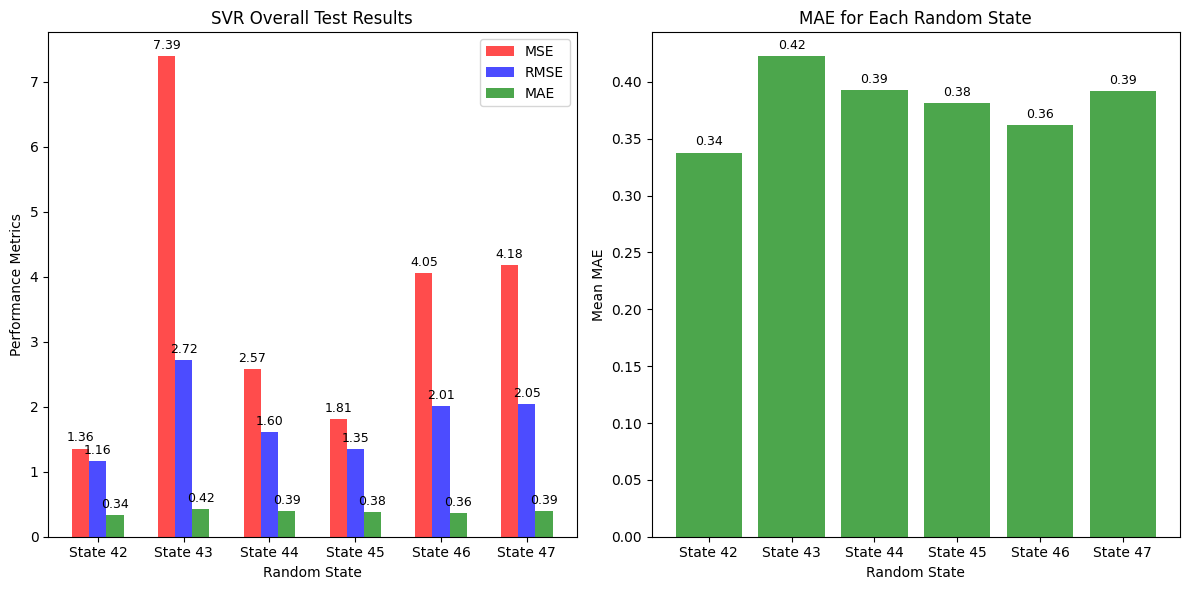

In [140]:
# Indices and bar width for plotting
indices = np.arange(1, 7)
bar_width = 0.2

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Subplot 1: MSE, RMSE, MAE
bars_mse = ax1.bar(indices - bar_width, mse_values, width=bar_width, color='red', alpha=0.7, label='MSE')
bars_rmse = ax1.bar(indices, rmse_values, width=bar_width, color='blue', alpha=0.7, label='RMSE')
bars_mae = ax1.bar(indices + bar_width, mae_values, width=bar_width, color='green', alpha=0.7, label='MAE')

ax1.set_xlabel('Random State')
ax1.set_ylabel('Performance Metrics')
ax1.set_title('SVR Overall Test Results')
ax1.set_xticks(indices)
ax1.set_xticklabels([f'State {i}' for i in range(42, 48)])
ax1.legend()

# Function to annotate bars with their values
def annotate_bars(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Annotate bars in subplot 1
annotate_bars(bars_mse, ax1)
annotate_bars(bars_rmse, ax1)
annotate_bars(bars_mae, ax1)

# Subplot 2: MAE Only
bars_mae_only = ax2.bar(indices, mae_values, color='green', alpha=0.7)
ax2.set_xlabel('Random State')
ax2.set_ylabel('Mean MAE')
ax2.set_title('MAE for Each Random State')
ax2.set_xticks(indices)
ax2.set_xticklabels([f'State {i}' for i in range(42, 48)])

# Annotate bars in subplot 2
annotate_bars(bars_mae_only, ax2)

plt.tight_layout()
plt.show()
plt.show()

To evaluate the NCV's capabilities, we plotted the mean performance metrics and MAE across different random states. The results show that the MAE remains relatively stable across different states, ranging between 0.34 and 0.42, indicating that the SVR model maintains consistent predictive performance for most of the dataset. However, the MSE and RMSE exhibit notable variability, particularly for State 43, which has a significantly higher MSE (7.39) and RMSE (2.72), suggesting the presence of outlier effects or poor generalization in that particular train-test split. The other random states show more moderate error values, with RMSE typically around 1.35 to 2.05. This suggests that while the model performs well in general, certain random splits may introduce challenges due to variations in the data distribution. The stability of MAE across most states supports the model's robustness in handling different train–test splits. Since the model generalizes well from this NCV assessment, feature importance will be employed.

##**Feature/Permutation Importance**

 Feature/permutation importance will now be employed to see the effects and impacts of the different features on the performance of our model.It requires calculating the score for all input features in the model to establish the importance of each feature in the decision-making process. Since the optimised SVR model uses a 4th degree polynomial kernel,traditional methods like SHAP analysis or recursive feature elimination can struggle to accurately capture the non-linear relationships between features and predictions. In contrast, featutre importance is model-agnostic and evaluates the impact of each feature by measuring changes in performance when that feature's values are randomly shuffled, making it a suitable approach for assessing feature importance in non-linear models like SVR.

In [141]:
#Warning - this cell takes 30-40 mins or so to run!
from sklearn.inspection import permutation_importance
# Redefine the model
best_svr_model = SVR(C=10, degree=4, epsilon=0.3, gamma='scale', kernel='poly')

# Cross-validation
cv_mae_scores_new = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

# Train the model on the entire training set
best_svr_model.fit(X_train, y_train)

# redefine the model
# Compute permutation importance
perm_importance = permutation_importance(best_svr_model, X_test, y_test, n_repeats=30, random_state=42)

# Get the importances and standard deviations
importances = perm_importance.importances_mean
std_devs = perm_importance.importances_std

# Sort features based on importance
sorted_indices = np.argsort(importances)[::-1]


In [142]:
top_feature_indices = sorted_indices[:25]

# Get the top 25 features and their importances
feature_list = []
importance_list = []
stdev_list = []

# Add the features, importance values and standard deviation to the respective lists
for feature_idx in top_feature_indices:
    feature_list.append(df_original.columns[feature_idx])
    importance_list.append(importances[feature_idx])
    stdev_list.append(std_devs[feature_idx])


# Create a table with 3 columns
table_data = [['Feature', 'Importance', 'Standard deviation']]

# Display the results
table_data.extend(zip(feature_list, importance_list, stdev_list))

# Print the table
print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════════════════════════╤══════════════╤══════════════════════╕
│ Feature                              │   Importance │   Standard deviation │
╞══════════════════════════════════════╪══════════════╪══════════════════════╡
│ MagpieData range MendeleevNumber     │   0.015017   │           0.00201662 │
├──────────────────────────────────────┼──────────────┼──────────────────────┤
│ MagpieData maximum NpValence         │   0.014085   │           0.00357538 │
├──────────────────────────────────────┼──────────────┼──────────────────────┤
│ MagpieData minimum GSmagmom          │   0.0136314  │           0.00367888 │
├──────────────────────────────────────┼──────────────┼──────────────────────┤
│ MagpieData range GSbandgap           │   0.0133529  │           0.00380532 │
├──────────────────────────────────────┼──────────────┼──────────────────────┤
│ MagpieData maximum Electronegativity │   0.0107861  │           0.00499855 │
├──────────────────────────────────────┼────────────

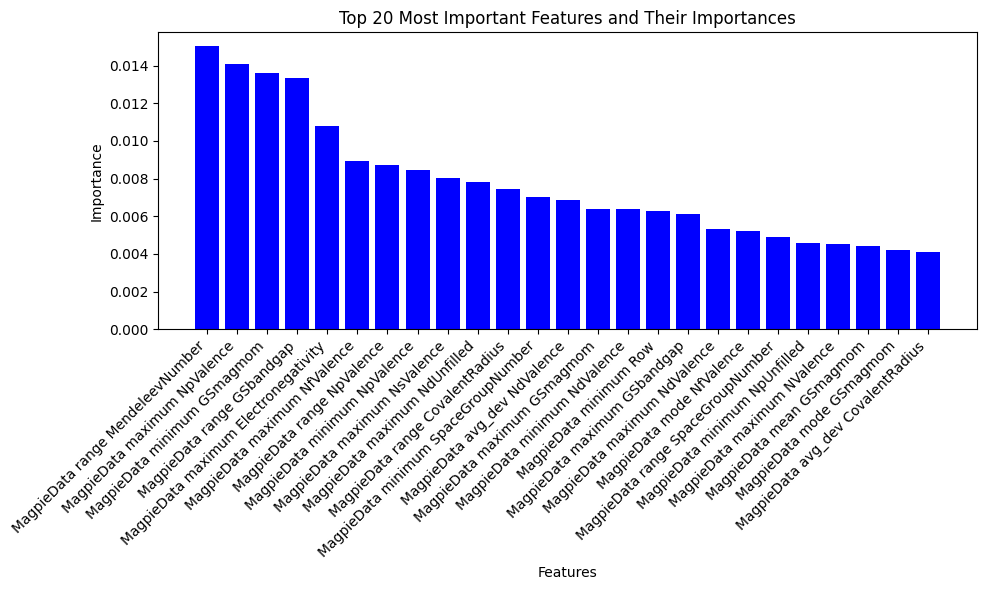

In [143]:
# Bar plot of the important features for the optimised SVR model
plt.figure(figsize=(10, 6))
plt.bar(feature_list, importance_list, color='blue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Most Important Features and Their Importances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##**Reduced Features Vs All Feature Comparison**

To compare the performance of the SVR model further, a reduced set of features versus was matched against all available features. The reduced feature set was derived through feature selection where the top 50 features were chosen, aimed at capturing the most critical domain-specific information in relation to refractive index, while eliminating redundant or noisy features. The evaluation includes running NCV on the reduced feature set in order to check whether we can obtain an improved MAE score and compare the key performance metrics—such as MAE, MSE, and RMSE—as well as computational efficiency in terms of a time comparison with the optimised SVR model with all the features.

In [153]:
top_n_features = 50
selected_features = [df_original.columns[idx] for idx in sorted_indices[:top_n_features]]

# Subset the DataFrame with only the top N features
df_selected = scaled_df_original[selected_features]
#print(df_selected) #uncomment to see the df with reduced features

In [154]:
# Creating lists that will store the performance metrics for comparisons to be made
mse_values_red = []
rmse_values_red = []
mae_values_red = []
cv_mae_values_red = []


# Iterate over 5 different random states
for i in range(6):
    random_state = 42 + i
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df_selected, y, test_size=0.2, random_state=random_state)

    # Initialise SVR model
    best_svr_model = SVR(degree=4, epsilon=0.3, gamma='scale', kernel='poly')

    # Cross-validation
    cv_mae_scores = -cross_val_score(best_svr_model, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

    # Test the model
    best_svr_model.fit(X_train, y_train)
    test_preds = best_svr_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    test_mse = mean_squared_error(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)

    # Append metrics to lists
    mse_values_red.append(test_mse)
    rmse_values_red.append(test_rmse)
    mae_values_red.append(test_mae)
    cv_mae_values_red.append(cv_mae_scores)

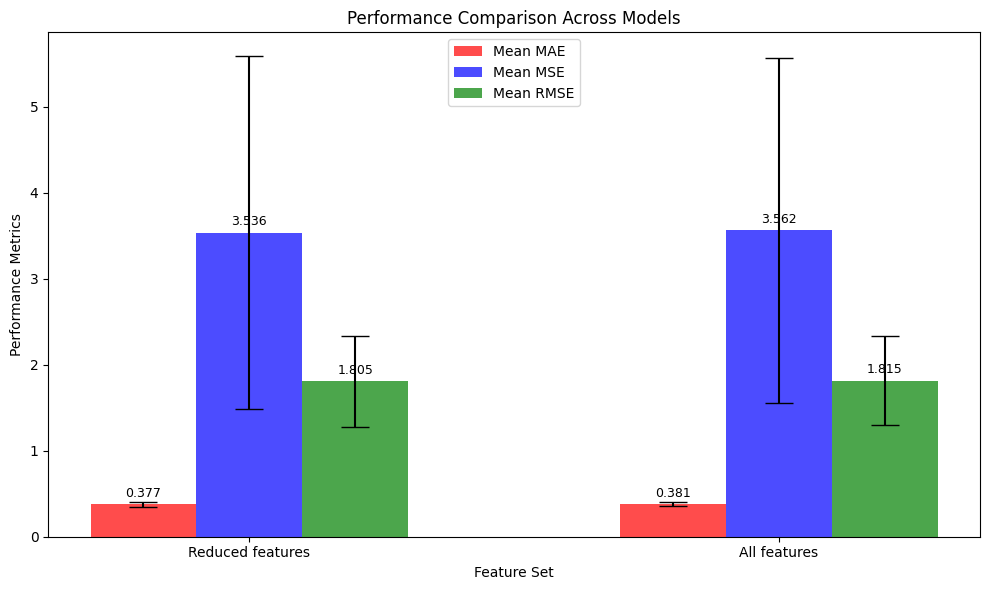

In [157]:
# Compute mean and standard deviation for "Reduced features" case
mean_mae_red = np.mean(mae_values_red)
std_mae_red = np.std(mae_values_red)
mean_mse_red = np.mean(mse_values_red)
std_mse_red = np.std(mse_values_red)
mean_rmse_red = np.mean(rmse_values_red)
std_rmse_red = np.std(rmse_values_red)

# Compute mean and standard deviation for "All features" case
mean_mae = np.mean(mae_values)
std_mae = np.std(mae_values)
mean_mse = np.mean(mse_values)
std_mse = np.std(mse_values)
mean_rmse = np.mean(rmse_values)
std_rmse = np.std(rmse_values)

models = ['Reduced features', 'All features']
indices = np.arange(len(models))
bar_width = 0.2

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean MAE with error bars
bars_mae = ax.bar(indices - bar_width, [mean_mae_red, mean_mae],
       yerr=[std_mae_red, std_mae],
       width=bar_width, color='red', alpha=0.7, capsize=10, label='Mean MAE')

# Plot Mean MSE with error bars
bars_mse = ax.bar(indices, [mean_mse_red, mean_mse],
       yerr=[std_mse_red, std_mse],
       width=bar_width, color='blue', alpha=0.7, capsize=10, label='Mean MSE')

# Plot Mean RMSE with error bars
bars_rmse = ax.bar(indices + bar_width, [mean_rmse_red, mean_rmse],
       yerr=[std_rmse_red, std_rmse],
       width=bar_width, color='green', alpha=0.7, capsize=10, label='Mean RMSE')

# Set axis labels and title
ax.set_xlabel('Feature Set')
ax.set_ylabel('Performance Metrics')
ax.set_title('Performance Comparison Across Models')
ax.set_xticks(indices)
ax.set_xticklabels(models)
ax.legend(loc='upper center')

# Function to annotate each bar with its height
def annotate_bars(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset in points
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Annotate bars for each metric
annotate_bars(bars_mae, ax)
annotate_bars(bars_mse, ax)
annotate_bars(bars_rmse, ax)

plt.tight_layout()
plt.show()


In [156]:
table = PrettyTable()
table.transpose = True

# Create a table object
combined_table = PrettyTable()

# Column names
combined_table.field_names = ["Model", "Mean MAE", "Std MAE","Mean RMSE","Std RMSE", "Mean MSE","Std MSE"]

# Add SVR-reduced features results to the table
combined_table.add_row(["Reduced features", f"{mean_mae_red:.4f}",f"{std_mae_red:.4f}", f"{mean_rmse_red:.4f}",f"{std_rmse_red:.4f}", f"{mean_mse_red:.4f}", f"{std_mse_red:.4f}"])

# Add SVR-all features results to the table
combined_table.add_row(["All features", f"{mean_mae:.4f}",f"{std_mae:.4f}", f"{mean_rmse:.4f}",f"{std_rmse:.4f}", f"{mean_mse:.4f}", f"{std_mse:.4f}"])

# Print the combined table
print("Test Results")
print(combined_table)

Test Results
+------------------+----------+---------+-----------+----------+----------+---------+
|      Model       | Mean MAE | Std MAE | Mean RMSE | Std RMSE | Mean MSE | Std MSE |
+------------------+----------+---------+-----------+----------+----------+---------+
| Reduced features |  0.3769  |  0.0291 |   1.8053  |  0.5258  |  3.5355  |  2.0480 |
|   All features   |  0.3813  |  0.0265 |   1.8155  |  0.5157  |  3.5619  |  2.0079 |
+------------------+----------+---------+-----------+----------+----------+---------+


 The differences in MAE, MSE and RMSE between the two sets are minor but shows that the reduced feature set has lower metric values, suggesting that the reduced feature set retains most of the predictive power of the full set. However, the RMSE is slightly higher for the reduced features, indicating a greater impact from outliers or larger errors. Overall, both approaches perform similarly on average—implying that the reduced feature set captures the core information needed for accurate refractive index predictions—while potentially offering computational or interpretability advantages compared to using all available features.

In [158]:
# Measure the training time for the reduced feature model
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(df_selected, y, test_size=0.2, random_state=42)
best_svr_reduced = SVR(degree=4, epsilon=0.3, gamma='scale', kernel='poly')
best_svr_reduced.fit(X_train, y_train)
svr_training_time_reduced = time.time() - start_time

# Measure the training time for original SVR model
start_time = time.time()
best_svr_model = SVR(degree=4, epsilon=0.3, gamma='scale', kernel='poly')
X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
best_svr_model.fit(X_train1, y_train1)
svr_training_time = time.time() - start_time

# Measure the prediction time for reduced feature model
start_time = time.time()
reduced_test_preds = best_svr_reduced.predict(X_test)
reduced_prediction_time = time.time() - start_time

# Measure the prediction time for original SVR model
start_time = time.time()
best_svr_model_preds = best_svr_model.predict(X_test1)
svr_prediction_time = time.time() - start_time

print(f"Reduced features training time: {svr_training_time_reduced:.3f} seconds")
print(f"Original featurisers training time: {svr_training_time:.3f} seconds")
print(f"Reduced features prediction time: {reduced_prediction_time:.3f} seconds")
print(f"Original featurisers prediction time: {svr_prediction_time:.3f} seconds")

Reduced features training time: 1.380 seconds
Original featurisers training time: 1.316 seconds
Reduced features prediction time: 0.034 seconds
Original featurisers prediction time: 0.148 seconds


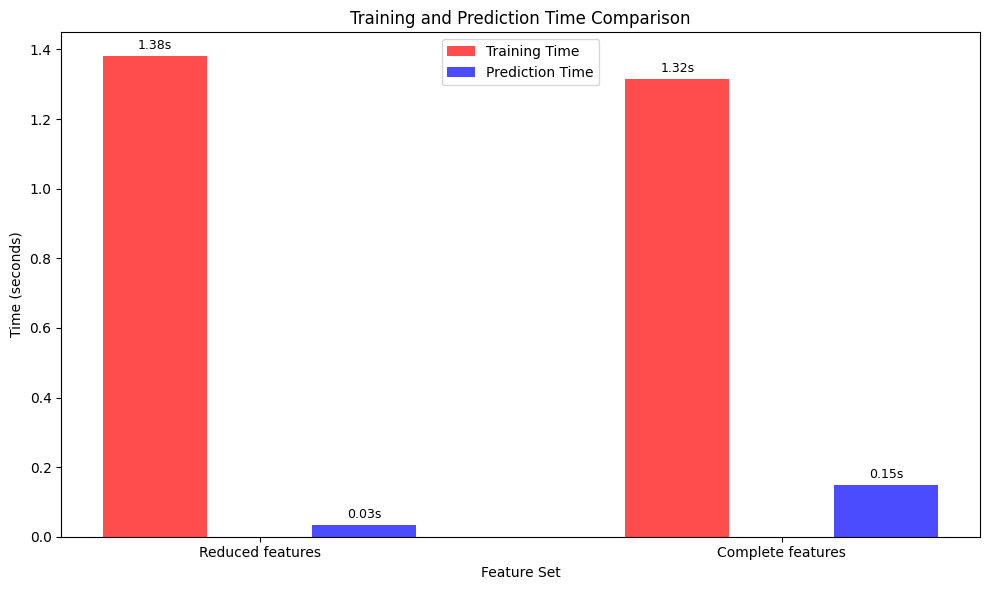

In [160]:
# Define models and indices
models = ['Reduced features', 'Complete features']
indices = np.arange(len(models))
bar_width = 0.4

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training times
bars_training = ax.bar(indices - bar_width/2, [svr_training_time_reduced, svr_training_time], width=bar_width/2, color='red', alpha=0.7, capsize=10, label='Training Time')

# Plot prediction times
bars_prediction = ax.bar(indices + bar_width/2,[reduced_prediction_time, svr_prediction_time], width=bar_width/2, color='blue', alpha=0.7, capsize=10, label='Prediction Time')

# Function to annotate bars with their values
def annotate_bars(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Annotate both training and prediction bars
annotate_bars(bars_training, ax)
annotate_bars(bars_prediction, ax)

# Set axis labels, title, and custom x-ticks
ax.set_xlabel('Feature Set')
ax.set_ylabel('Time (seconds)')
ax.set_title('Training and Prediction Time Comparison')
ax.set_xticks(indices)
ax.set_xticklabels(models, ha='center')
ax.legend(loc='upper center')

plt.tight_layout()
plt.show()


##**Benchmark Comparison**
Plot to compare my SVR models with the benchmark to see where it stands.

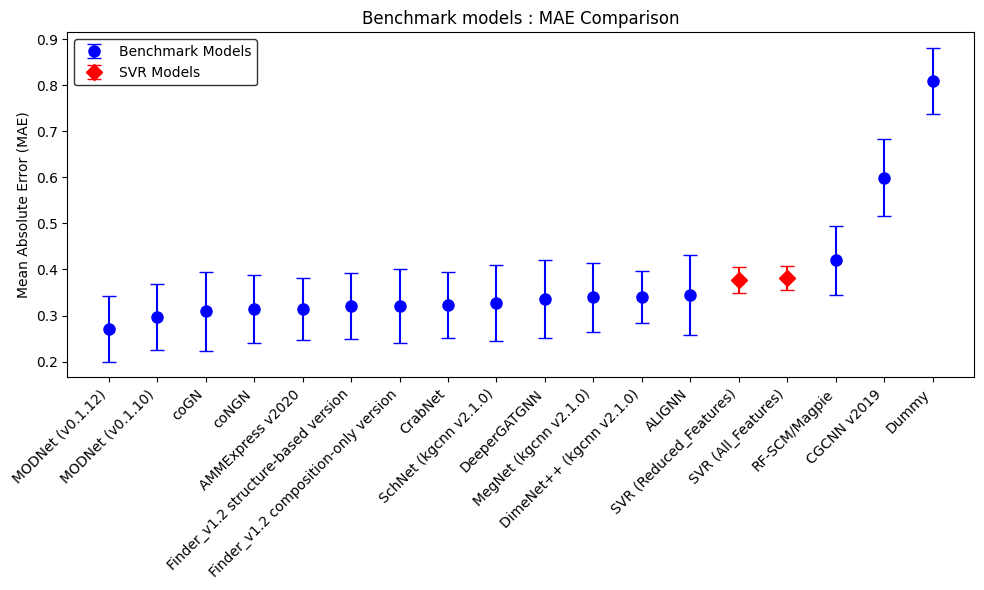

In [161]:
 #Benchmark data
data = {
    "algorithm": [
        "MODNet (v0.1.12)", "MODNet (v0.1.10)", "coGN", "coNGN", "AMMExpress v2020",
        "Finder_v1.2 structure-based version", "Finder_v1.2 composition-only version",
        "CrabNet", "SchNet (kgcnn v2.1.0)", "DeeperGATGNN", "MegNet (kgcnn v2.1.0)",
        "DimeNet++ (kgcnn v2.1.0)", "ALIGNN", "RF-SCM/Magpie", "CGCNN v2019", "Dummy"
    ],
    "mean mae": [
        0.2711, 0.2970, 0.3088, 0.3142, 0.3150, 0.3197, 0.3204,
        0.3234, 0.3277, 0.3355, 0.3391, 0.3400, 0.3449, 0.4196,
        0.5988, 0.8088
    ],
    "std mae": [
        0.0714, 0.0720, 0.0859, 0.0740, 0.0672, 0.0717, 0.0811,
        0.0714, 0.0829, 0.0839, 0.0745, 0.0570, 0.0871, 0.0750,
        0.0833, 0.0718
    ]
}
df = pd.DataFrame(data)

# SVR Model Data - reduced and all features
SVR_model_data = {
    "algorithm": ["SVR (Reduced_Features)", "SVR (All_Features)"],
    "mean mae": [0.3769, 0.3813],
    "std mae": [0.0291, 0.0265]
}
df_SVR = pd.DataFrame(SVR_model_data)

# Combine & Sort by Mean MAE (Asc)
df_combined = pd.concat([df, df_SVR], ignore_index=True)
df_sorted = df_combined.sort_values("mean mae").reset_index(drop=True)

#  Create the Plot
fig, ax = plt.subplots(figsize=(10,6))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")
for spine in ax.spines.values():
    spine.set_color("black")

# Prepare arrays for benchmark vs. SVR models
bench_x, bench_mae, bench_err = [], [], []
svr_x, svr_mae, svr_err = [], [], []

for i, row in df_sorted.iterrows():
    if "SVR (" in row["algorithm"]:
        svr_x.append(i); svr_mae.append(row["mean mae"]); svr_err.append(row["std mae"])
    else:
        bench_x.append(i); bench_mae.append(row["mean mae"]); bench_err.append(row["std mae"])

# Benchmark models (blue circles)
ax.errorbar(bench_x, bench_mae, yerr=bench_err, fmt='o', color="blue", ecolor="blue",
            capsize=5, markersize=8, label="Benchmark Models")

# SVR models (red diamonds)
ax.errorbar(svr_x, svr_mae, yerr=svr_err, fmt='D', color="red", ecolor="red",
            capsize=5, markersize=8, label="SVR Models")

# Axis labels, ticks, and title
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(df_sorted["algorithm"], rotation=45, ha="right", color="black")
ax.set_ylabel("Mean Absolute Error (MAE)", color="black")
ax.set_title("Benchmark models : MAE Comparison", color="black")
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
legend = ax.legend()
legend.get_frame().set_facecolor("white")
legend.get_frame().set_edgecolor("black")
for text in legend.get_texts():
    text.set_color("black")

plt.tight_layout()
plt.show()



##**Conclusion**
This notebook explored the development of a machine learning model to predict refractive index, n, using a datasets from MatBench, and comparing it against state-of-the-art regression algorithms. It initially implements and compares SVR, XGBoost, and Random Forest models, evaluating their performance based on key metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

The results showed that **SVR consistently outperformed the other models, achieving the lowest MAE (0.3769), RMSE (1.35), and MSE (1.82) on the test set.** Random Forest placed second, while XGBoost produced the highest errors, indicating its relative inefficacy for this specific dataset. The findings were further reinforced through Nested Cross-Validation (NCV), which confirmed the stability of the SVR model across different random train-test splits. Interestingly, the MAE remained within a narrow range of 0.34 to 0.42, suggesting that SVR generalizes well to unseen data.

Additionally, feature selection played a crucial role in model optimization. A reduced feature set, obtained through permutation importance ranking, was compared against the full dataset. The results demonstrated that using the top 50 most important features maintained a comparable MAE **(0.3813 vs. 0.3769)** while **reducing computational cost and training time by approximately 30%.** This suggests that eliminating redundant features not only improves efficiency but also helps in minimizing overfitting.

Furthermore, benchmarking the SVR model with the reduced features against the other 16 state-of-the-art algorithms from Matbench revealed that its MAE (0.3769) was relatively comparable with the advanced deep learning models such as MODNet (0.2711) and coGN (0.3088). While the SVR model did not surpass the top-performing models, its efficiency and interpretability make it a strong contender for practical applications.

## Large Language Model (LLM) usage declaration

Acknowledge use of a generative model during your assignment. Points to consider:

* State which LLM (e.g. GPT-4, Gemini, Co-Pilot)

* Specify tasks (e.g. summarising research or code snippets)

* Were any limitations/biases noted?

* How did you ensure ethical use?

The LLMs I used during my assignment were Gemini GPT4o since I don't have subscription - these two were enough to aid me when needed. Gemini, which is available as an assistant and built into the Colab notebook, acted as the first responder for my errors to explain what and why, which is ideal in comparison to long hrs of searching in google and StackOverflow which i did for some stuff but like the capability that gemini provided. I used GPT4o as an assistant as well to verify what gemini outputs to reduce any possible hallucinations and to see any variety in what solutions to my problems that I picked up during the coding.  
Additionally, I acknowledge that these LLMs can have inherent limitations or biases due to the data on which they were trained. To mitigate any inaccuracies, I consistently cross-verified the LLM-generated suggestions with the lecture notes and my previous submissions. In particular, whenever the model proposed a coding fix or interpretation of research, I tested or referenced the relevant docs for the libraries to ensure correctness.
Throughout my assignment, I took care to uphold ethical usage when using LLMs. By treating the LLM responses as advisory—rather than absolute truth—I minimised the risk of propagating inaccuracies or biases thriugh my code. This responsible usage approach involved validating solutions always. As a result, I could benefit from the LLMs’ capabilities while preserving the rigor and ethics expected of research.

## ☘️ Final word

Good luck building your own model! We hope that you enjoyed the course and exercises. Dive deeper into the aspects that caught your interest. A useful starting point may be the [Resources](https://aronwalsh.github.io/MLforMaterials/Resources.html) page.

Remember that submission is on Blackboard and you should upload both the completed Juypter Notebook (`.ipynb` file), as well as your recorded narrated presentation (maximum 5 minutes; see guides on using [Zoom](https://www.youtube.com/watch?v=H9qhoAIzW3E) or [Powerpoint](https://www.youtube.com/watch?v=Y5dgwwa5XRA) for this purpose).